In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor
from functions import *

In [2]:
train = pd.read_csv("../data/train_nocat_hh.csv", index_col = 'tstp')
test = pd.read_csv("../data/test_nocat_hh.csv", index_col = 'tstp')

In [3]:
train = extract_dmhq(train)
test = extract_dmhq(test)

### Seeking outliers

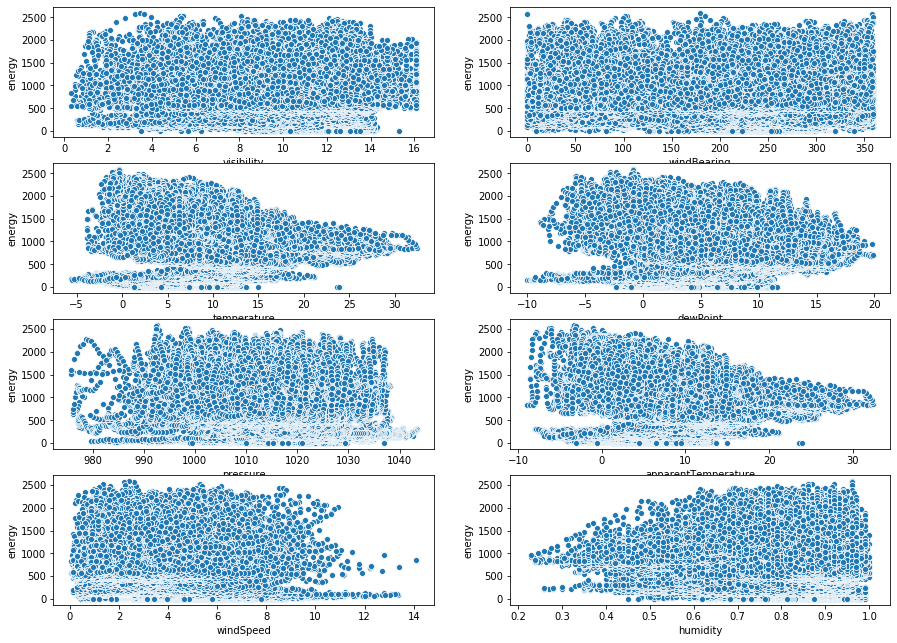

In [4]:
scatter_plot(train)

### Calibration of distribution

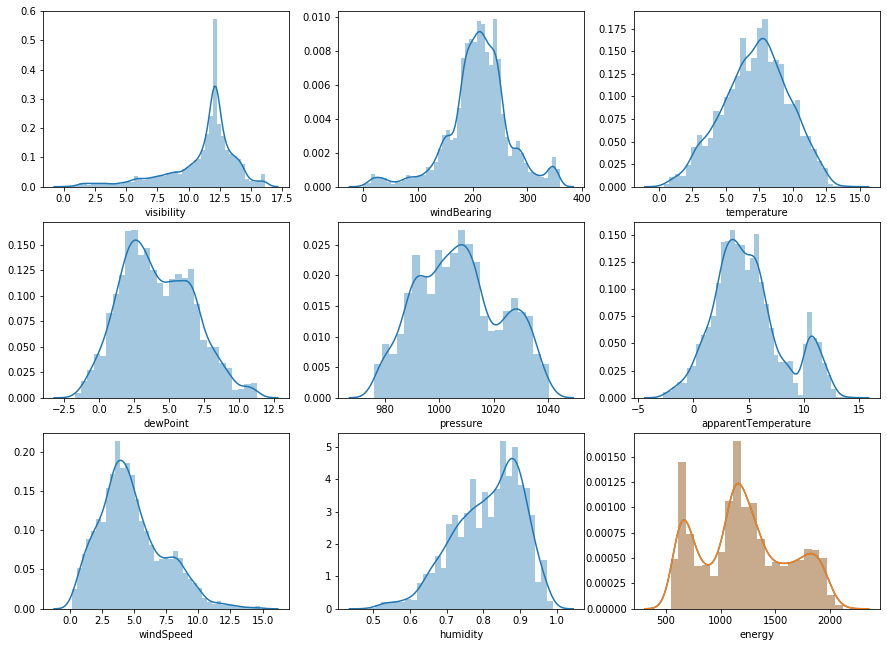

In [5]:
distri_plot(test)


We can observe that 
- left skew: **visibility**, **humidty** 
- right skew:  **windSpeed**, **temperature**
- weird shape: **windBearing**, **dewPoint**, **apparetTemp**

Apply transformation on them for more normal distribution

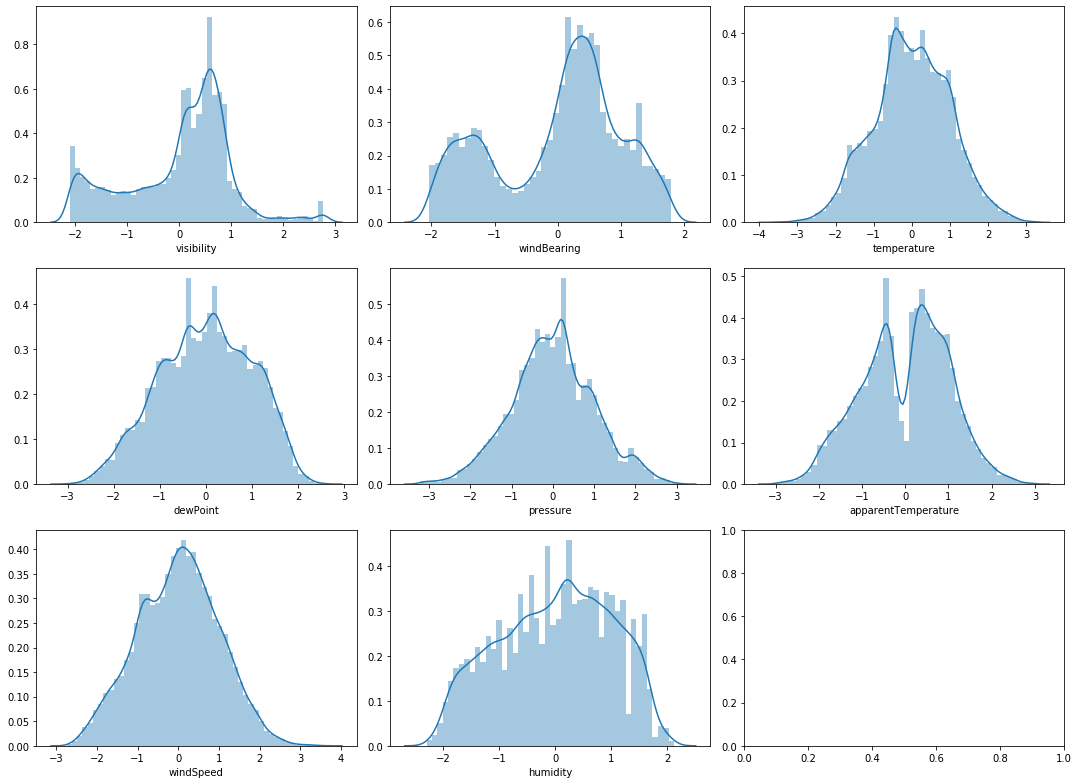

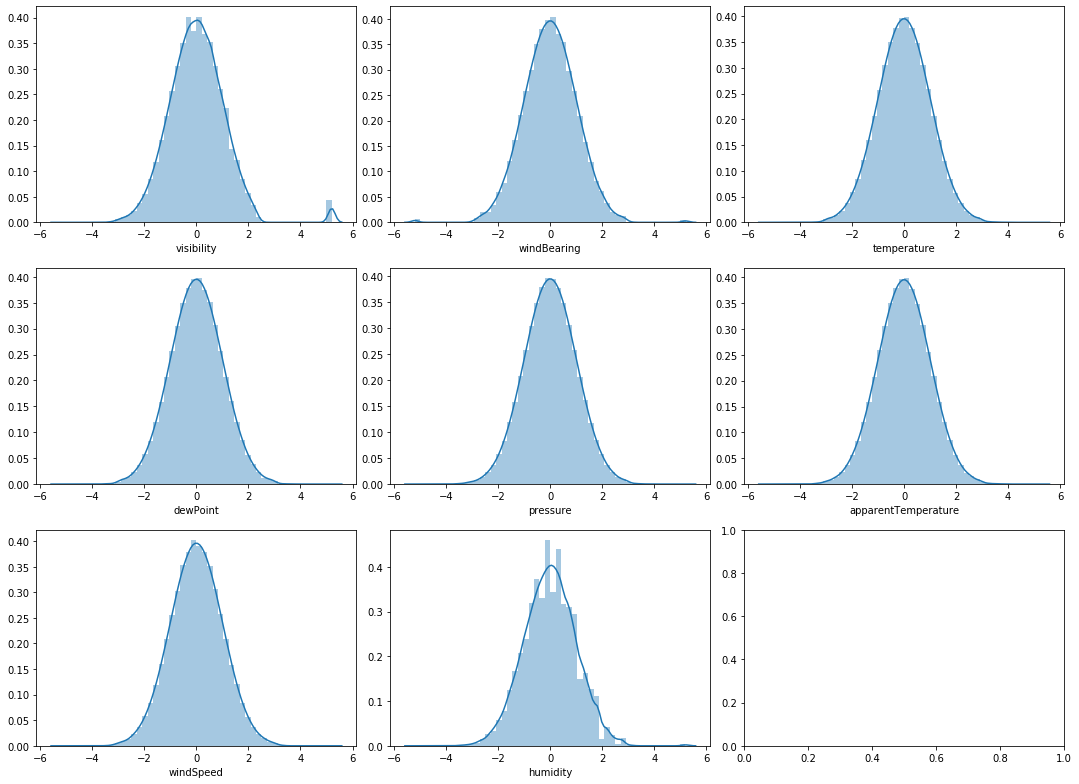

In [6]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer 
    
def power_trans(df):
    pt = PowerTransformer(method = "yeo-johnson")
    df_slice = df.iloc[:,:8]
    pt.fit(X = df_slice)
    df_trans = pd.DataFrame(pt.transform(df_slice), columns=train.columns[:8])
    return df_trans

train_trans = power_trans(train)

def quantile_trans(df):
    rng = np.random.RandomState(304)
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
    df_slice = df.iloc[:,:8]
    qt.fit(df_slice)
    df_trans = pd.DataFrame(qt.transform(df_slice), columns=train.columns[:8])
    return df_trans

train_trans = power_trans(train)
train_quantile = quantile_trans(train)

##plot distribution
distri_plot(train_trans)
distri_plot(train_quantile)

### Creat lag ahead scenarios

In [4]:
ftrain, ttrain = feature_target_construct(train, 96, 96, 20, 2)
ftest, ttest = feature_target_construct(test, 96, 96, 20, 2)

In [5]:
ftrain

,month,day,wd,minute,hour,temperature1(t-20),temperature1(t-18),temperature1(t-16),temperature1(t-14),temperature1(t-12),...,energy1(t-9),energy1(t-8),energy1(t-7),energy1(t-6),energy1(t-5),energy1(t-4),energy1(t-3),energy1(t-2),energy1(t-1),LCLid
tstp,,,,,,,,,,,,,,,,,,,,,
2011-11-25 09:00:00,11,25,4,0,9,11.480,11.910,11.990,12.520,12.610,...,3.960000,3.508000,3.333000,3.776000,3.697000,3.728000,4.570,4.767,4.476,26
2011-11-25 09:30:00,11,25,4,30,9,11.695,11.950,12.255,12.565,12.810,...,3.508000,3.333000,3.776000,3.697000,3.728000,4.570000,4.767,4.476,5.009,26
2011-11-25 10:00:00,11,25,4,0,10,11.910,11.990,12.520,12.610,13.010,...,3.333000,3.776000,3.697000,3.728000,4.570000,4.767000,4.476,5.009,4.445,27
2011-11-25 10:30:00,11,25,4,30,10,11.950,12.255,12.565,12.810,13.020,...,3.776000,3.697000,3.728000,4.570000,4.767000,4.476000,5.009,4.445,4.984,28
2011-11-25 11:00:00,11,25,4,0,11,11.990,12.520,12.610,13.010,13.030,...,3.697000,3.728000,4.570000,4.767000,4.476000,5.009000,4.445,4.984,4.371,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-11-21 22:00:00,11,21,3,0,22,6.790,7.340,7.910,7.740,7.160,...,1824.489001,1879.115003,1989.827999,2030.098000,2004.464998,1930.846001,1873.589,1827.745,1745.972,5142
2013-11-21 22:30:00,11,21,3,30,22,7.065,7.625,7.825,7.450,6.870,...,1879.115003,1989.827999,2030.098000,2004.464998,1930.846001,1873.589000,1827.745,1745.972,1664.640,5142
2013-11-21 23:00:00,11,21,3,0,23,7.340,7.910,7.740,7.160,6.580,...,1989.827999,2030.098000,2004.464998,1930.846001,1873.589000,1827.745000,1745.972,1664.640,1538.203,5142


### Scaling 

In [7]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler() ## will be used later in test set
mmscaler.fit(ftrain)
mt = mmscaler.transform(ftrain)


### Feature Selection

In [8]:
from sklearn.tree import ExtraTreeRegressor
from sklearn.feature_selection import SelectFromModel
reg = ExtraTreeRegressor(criterion='mse', 
                         max_depth=None, min_samples_split=10, 
                         min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                         max_features='auto', max_leaf_nodes=None, 
                         min_impurity_decrease=0.0, min_impurity_split=None, 
                         random_state=31, 
                         ccp_alpha=0.0).fit(mt, ttrain)
model = SelectFromModel(reg, prefit=True)
cols = model.get_support(indices=True)
mt_feature = model.transform(mt)
cols ## the selected features column

array([ 7, 20, 28, 42, 47, 51, 55])

### Extra Trees Regression

In [38]:
# Tree based feature selection
from sklearn.tree import ExtraTreeRegressor
from sklearn.feature_selection import SelectFromModel
etr = ExtraTreeRegressor(criterion='mse', 
                         max_depth=None, min_samples_split=10, 
                         min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                         max_features='auto', max_leaf_nodes=None, 
                         min_impurity_decrease=0.0, min_impurity_split=None, 
                         random_state=31, 
                         ccp_alpha=0.0)
metr = ExtraTreeRegressor(criterion='mse', 
                         max_depth=None, min_samples_split=10, 
                         min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                         max_features='auto', max_leaf_nodes=None, 
                         min_impurity_decrease=0.0, min_impurity_split=None, 
                         random_state=31, 
                         ccp_alpha=0.0)
X = ftrain
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)


%time etr.fit(train_X, train_y.iloc[:,0])
%time metr.fit(train_X, train_y)

CPU times: user 314 ms, sys: 2.74 ms, total: 317 ms
Wall time: 318 ms
CPU times: user 728 ms, sys: 8.71 ms, total: 737 ms
Wall time: 737 ms


ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                   max_features='auto', max_leaf_nodes=None,
                   min_impurity_decrease=0.0, min_impurity_split=None,
                   min_samples_leaf=1, min_samples_split=10,
                   min_weight_fraction_leaf=0.0, random_state=31,
                   splitter='random')

### regressorchain_multi + Multioutput_multi


In [46]:
from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor
rcetr = RegressorChain(etr)
%time rcetr.fit(train_X, train_y)
moetr = MultiOutputRegressor(etr, n_jobs = 4)
%time moetr.fit(train_X, train_y)

CPU times: user 43.7 s, sys: 332 ms, total: 44 s
Wall time: 44.1 s
CPU times: user 348 ms, sys: 267 ms, total: 615 ms
Wall time: 11.2 s


MultiOutputRegressor(estimator=ExtraTreeRegressor(ccp_alpha=0.0,
                                                  criterion='mse',
                                                  max_depth=None,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=10,
                                                  min_weight_fraction_leaf=0.0,
                                                  random_state=31,
                                                  splitter='random'),
                     n_jobs=4)

### Validation set

**single**

In [49]:
ypred = etr.predict(val_X).reshape(1,-1)
o_y = np.transpose(val_y.iloc[:1000,1].to_numpy().reshape(1,-1))
p_y = np.transpose(ypred[:,:1000])
get_eval(o_y, p_y)

MSE: 6514.253514103507
MAE: 50.19236061152095
r2_score: 0.9757227921268334


**multi_direct**

In [64]:
ypred = metr.predict(val_X)
o_y = np.transpose(val_y.iloc[1000,:95].to_numpy().reshape(1,-1))
p_y = np.transpose(ypred[1000,:95].reshape(1,-1))
get_eval(o_y, p_y)

MSE: 2392.111923794946
MAE: 40.18634857614035
r2_score: 0.9512531556730379


**Multioutput**

In [65]:
ypred = moetr.predict(val_X)
o_y = np.transpose(val_y.iloc[1000,:95].to_numpy().reshape(1,-1))
p_y = np.transpose(ypred[1000,:95].reshape(1,-1))
get_eval(o_y, p_y)

MSE: 1970.1399968645233
MAE: 28.381405885899728
r2_score: 0.9598521679633126


**RegressorChain**

In [66]:
ypred = rcetr.predict(val_X)
o_y = np.transpose(val_y.iloc[1000,:95].to_numpy().reshape(1,-1))
p_y = np.transpose(ypred[1000,:95].reshape(1,-1))
get_eval(o_y, p_y)

MSE: 2901.5858647648442
MAE: 36.44628375027025
r2_score: 0.9408710131645455


### Testing set

In [98]:
ypred = etr.predict(ftest).reshape(1,-1)
o_y = np.transpose(ttest.iloc[:1000,0].to_numpy().reshape(1,-1))
p_y = np.transpose(ypred[0,:1000])
get_eval(o_y, p_y)

MSE: 2646.391581579373
MAE: 37.348603162254044
r2_score: 0.9835748470479282


In [103]:
ypred = metr.predict(ftest)
o_y = np.transpose(ttest.iloc[:4400,:95].to_numpy().reshape(1,-1))
p_y = np.transpose(ypred[:4400,:95].reshape(1,-1))
get_eval(o_y, p_y)

MSE: 22026.50362955218
MAE: 104.01847835184711
r2_score: 0.8615077102207582


In [102]:
ypred = moetr.predict(ftest)
o_y = np.transpose(ttest.iloc[:4400,:95].to_numpy().reshape(1,-1))
p_y = np.transpose(ypred[:4400,:95].reshape(1,-1))
get_eval(o_y, p_y)

MSE: 21269.061228039787
MAE: 91.33470507804613
r2_score: 0.8662701516107116


In [101]:
ypred = rcetr.predict(ftest)
o_y = np.transpose(ttest.iloc[:4400,:95].to_numpy().reshape(1,-1))
p_y = np.transpose(ypred[:4400,:95].reshape(1,-1))
get_eval(o_y, p_y)

MSE: 21407.969965016327
MAE: 99.34453438217658
r2_score: 0.8653967588390866


### Testing set

In [13]:
## feature scaling
# single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
mtest = mmscaler.transform(ftest)

## feature pick up
test_x = mtest[:,cols]
test_y = ttest
ypred_t = etr.predict(test_x[:,:])
o_y = np.transpose(test_y.iloc[:1000,:].to_numpy())
p_y = np.transpose(ypred_t[:1000,:])
get_eval(o_y, p_y)

MSE: 21535.747227074982
MAE: 103.10166112066827
r2_score: 0.8665530203807114


In [15]:
mean, err = ci_construct((ypred_t- test_y), 1.96)
ypred_t_ub = ypred_t + err + mean
ypred_t_lb = ypred_t - err +mean

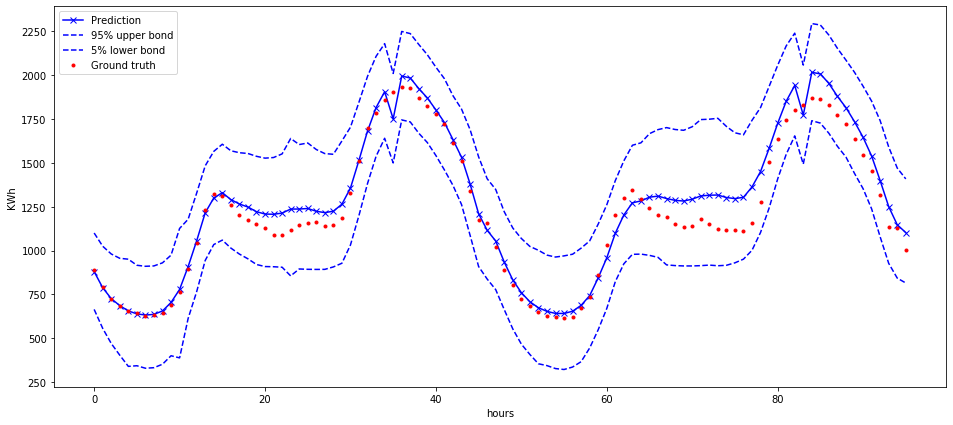

In [16]:
fig = plt.figure(figsize=(16,7))

plt.plot(ypred_t[50:51,:].reshape(-1,1), 'bx-',label='Prediction')
plt.plot(ypred_t_ub[50:51,:].reshape(-1,1), 'b--', label='95% upper bond')
plt.plot(ypred_t_lb[50:51,:].reshape(-1,1), 'b--', label='5% lower bond')
plt.plot(test_y.iloc[50:51,:].to_numpy().reshape(-1,1), 'r.', label='Ground truth', lw = 3)
#plt.fill(np.concatenate([xx, xx[::-1]]),
#         np.concatenate([y_upper, y_lower[::-1]]),
#         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('hours')
plt.ylabel('KWh')
plt.legend(loc='upper left')
plt.show()

### HistGradientBoostingRegression

In [48]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor
hgb = HistGradientBoostingRegressor(loss='least_squares', 
                                    learning_rate=0.1, 
                                    max_iter=100, 
                                    max_leaf_nodes=3, 
                                    max_depth=None, 
                                    min_samples_leaf=20, 
                                    l2_regularization=0.0, 
                                    max_bins=50, 
                                    warm_start=False, 
                                    scoring=None, 
                                    validation_fraction=0.1, 
                                    n_iter_no_change=None, 
                                    tol=1e-07, 
                                    verbose=0, 
                                    random_state=None)
mhgb = RegressorChain(hgb)


In [51]:
from sklearn.model_selection import train_test_split
X = mt_feature
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

%time mhgb.fit(train_X, train_y)

CPU times: user 3min 50s, sys: 8.87 s, total: 3min 59s
Wall time: 34.4 s


RegressorChain(base_estimator=HistGradientBoostingRegressor(l2_regularization=0.0,
                                                            learning_rate=0.1,
                                                            loss='least_squares',
                                                            max_bins=50,
                                                            max_depth=None,
                                                            max_iter=100,
                                                            max_leaf_nodes=3,
                                                            min_samples_leaf=20,
                                                            n_iter_no_change=None,
                                                            random_state=None,
                                                            scoring=None,
                                                            tol=1e-07,
                                                            validat

### Validation set

In [60]:
ypred = mhgb.predict(val_X[:,:])

In [62]:
o_y = np.transpose(val_y.iloc[:100,:].to_numpy())
p_y = np.transpose(ypred[:100,:])
get_eval(o_y, p_y)

MSE: 17345.34257242298
MAE: 92.21929272954527
r2_score: 0.8122872893223996


### Testing set

In [54]:
## feature scaling
# single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
mtest = mmscaler.transform(ftest)

## feature pick up
test_x = mtest[:,cols]
test_y = ttest

In [55]:
ypred_t = mhgb.predict(test_x[:,:])

In [83]:
o_yt = np.transpose(test_y.iloc[:1,:].to_numpy())
p_yt = np.transpose(ypred_t[:1,:])
get_eval(o_yt, p_yt)

MSE: 37959.24969197703
MAE: 149.07764787431438
r2_score: 0.7671225764718457


**Create Std: static method**

In [84]:
error_list = []
for idx in range(96):
    error_list.append(mean_squared_error(ypred_t[:,idx], test_y.iloc[:,idx]) ** 0.5)
err = np.reshape(error_list, (1, 96))
ypred_t_ub = ypred_t +3*err
ypred_t_lb = ypred_t - 3*err

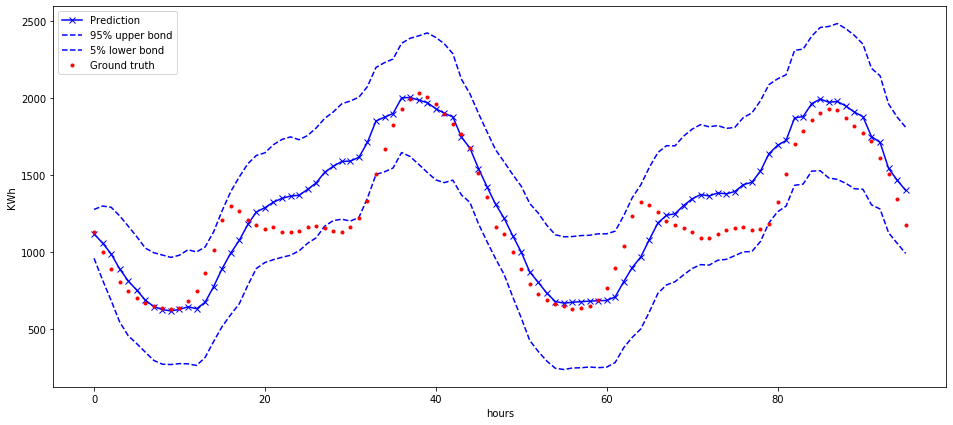

In [85]:
fig = plt.figure(figsize=(16,7))

plt.plot(ypred_t[:1,:].reshape(-1,1), 'bx-',label='Prediction')
plt.plot(ypred_t_ub[:1,:].reshape(-1,1), 'b--', label='95% upper bond')
plt.plot(ypred_t_lb[:1,:].reshape(-1,1), 'b--', label='5% lower bond')
plt.plot(test_y.iloc[:1,:].to_numpy().reshape(-1,1), 'r.', label='Ground truth', lw = 3)
#plt.fill(np.concatenate([xx, xx[::-1]]),
#         np.concatenate([y_upper, y_lower[::-1]]),
#         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('hours')
plt.ylabel('KWh')
plt.legend(loc='upper left')
plt.show()

**Create Std: fit error method**

In [70]:
validation_error = (ypred - val_y)  

In [71]:
emhgb = RegressorChain(hgb)
%time emhgb.fit(val_X, validation_error) 

CPU times: user 2min 24s, sys: 7.17 s, total: 2min 31s
Wall time: 19.5 s


RegressorChain(base_estimator=HistGradientBoostingRegressor(l2_regularization=0.0,
                                                            learning_rate=0.1,
                                                            loss='least_squares',
                                                            max_bins=50,
                                                            max_depth=None,
                                                            max_iter=100,
                                                            max_leaf_nodes=3,
                                                            min_samples_leaf=20,
                                                            n_iter_no_change=None,
                                                            random_state=None,
                                                            scoring=None,
                                                            tol=1e-07,
                                                            validat

In [78]:
validation_error

,energy1(t+0),energy1(t+1),energy1(t+2),energy1(t+3),energy1(t+4),energy1(t+5),energy1(t+6),energy1(t+7),energy1(t+8),energy1(t+9),...,energy1(t+86),energy1(t+87),energy1(t+88),energy1(t+89),energy1(t+90),energy1(t+91),energy1(t+92),energy1(t+93),energy1(t+94),energy1(t+95)
tstp,,,,,,,,,,,,,,,,,,,,,
2012-01-22 10:30:00,-19.438996,0.541811,-7.958602,-2.698596,-18.968889,-4.464759,-14.130742,-11.655572,-6.403502,4.461557,...,72.386089,62.439485,55.546164,42.055159,31.138579,13.394566,10.261520,28.217728,29.104751,27.582333
2012-12-18 15:21:06,8.689401,11.166389,17.706234,20.673407,39.711565,56.070565,28.347557,133.194650,60.974255,144.754473,...,318.748267,361.916620,341.124530,338.976172,349.365318,350.807894,313.981129,361.511846,313.353959,313.477380
2012-12-04 03:30:00,12.447768,30.067173,60.723427,100.926273,68.489926,76.264034,2.727626,-79.085929,-144.028810,-205.492614,...,-129.488064,-107.096976,-10.468772,98.011455,13.126128,49.686271,74.531527,57.282959,4.002445,33.522988
2013-02-22 07:00:00,-26.344860,-88.018136,-133.622022,-177.018533,-179.304689,-149.926970,-100.255684,-41.351156,-81.964018,-48.623953,...,118.619210,138.814452,137.649407,107.243898,86.179447,60.902057,101.772028,91.398223,91.237922,88.229069
2012-01-08 23:30:00,14.290431,38.760559,19.119111,29.587851,49.295683,51.404008,61.994845,57.531933,65.995992,68.940763,...,-46.235659,-44.529262,-32.818309,-29.929106,-32.064249,-30.513969,-26.783864,-9.089906,-1.434268,11.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-03 19:00:00,95.329876,76.839087,124.561996,151.946827,167.497236,210.525819,161.471367,36.439172,55.354074,154.504778,...,-226.200087,-199.946609,-179.817756,-149.566586,-105.065256,-75.593815,-113.668929,-48.279426,18.140480,41.893531
2012-09-27 07:30:00,-1.235536,62.880998,56.683213,59.596371,80.854978,97.020226,81.799108,80.505063,66.185700,52.932248,...,5.844103,7.250413,18.854040,26.268157,67.254449,114.956198,176.155575,166.449246,127.104181,58.950062
2013-01-24 23:30:00,81.931083,45.761834,147.054532,153.234601,131.542684,94.827251,51.868962,55.538809,63.845420,52.182991,...,-161.508685,-90.184198,97.571054,165.456968,206.004961,252.598875,253.443974,281.603311,206.702677,265.822339


In [73]:
st_dev.shape

(4466, 96)

In [76]:
ypred_t_ub = ypred_t +3*st_dev[:,:]
ypred_t_lb = ypred_t - 3*st_dev[:,:]

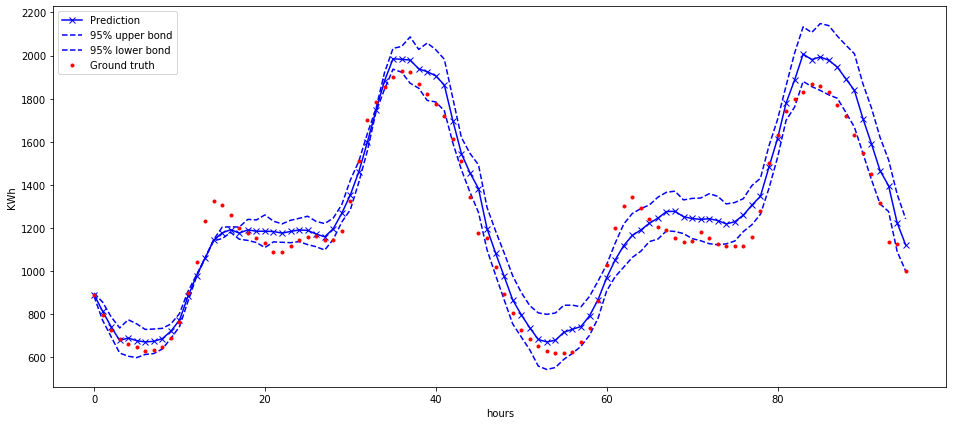

In [77]:
fig = plt.figure(figsize=(16,7))

plt.plot(ypred_t[50:51,:].reshape(-1,1), 'bx-',label='Prediction')
plt.plot(ypred_t_ub[50:51,:].reshape(-1,1), 'b--', label='95% upper bond')
plt.plot(ypred_t_lb[50:51,:].reshape(-1,1), 'b--', label='95% lower bond')
plt.plot(test_y.iloc[50:51,:].to_numpy().reshape(-1,1), 'r.', label='Ground truth', lw = 3)
#plt.fill(np.concatenate([xx, xx[::-1]]),
#         np.concatenate([y_upper, y_lower[::-1]]),
#         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('hours')
plt.ylabel('KWh')
plt.legend(loc='upper left')
plt.show()

### Gradient Boosting Regression

In [173]:
from sklearn.ensemble import GradientBoostingRegressor
# lower bond
gbr_lb = GradientBoostingRegressor(loss='quantile', learning_rate=0.1, 
                                n_estimators=100, subsample=1.0, 
                                criterion='friedman_mse', min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_depth=3, min_impurity_decrease=0.0, 
                                min_impurity_split=None, init=None, 
                                random_state=None, max_features=None, 
                                alpha=0.95, verbose=0, 
                                max_leaf_nodes=None, warm_start=False, 
                                presort='deprecated', validation_fraction=0.1, 
                                n_iter_no_change=None, tol=0.0001, 
                                ccp_alpha=0.0)
mlr_lb = MultiOutputRegressor(gbr_lb, n_jobs=4)
# upper bond
gbr_ub = GradientBoostingRegressor(loss='quantile', learning_rate=0.1, 
                                n_estimators=100, subsample=1.0, 
                                criterion='friedman_mse', min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_depth=3, min_impurity_decrease=0.0, 
                                min_impurity_split=None, init=None, 
                                random_state=None, max_features=None, 
                                alpha=0.05, verbose=0, 
                                max_leaf_nodes=None, warm_start=False, 
                                presort='deprecated', validation_fraction=0.1, 
                                n_iter_no_change=None, tol=0.0001, 
                                ccp_alpha=0.0)
mlr_ub = MultiOutputRegressor(gbr_ub, n_jobs=4)
# prediction
gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, 
                                n_estimators=100, subsample=1.0, 
                                criterion='friedman_mse', min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_depth=3, min_impurity_decrease=0.0, 
                                min_impurity_split=None, init=None, 
                                random_state=None, max_features=None, 
                                verbose=0, 
                                max_leaf_nodes=None, warm_start=False, 
                                presort='deprecated', validation_fraction=0.1, 
                                n_iter_no_change=None, tol=0.0001, 
                                ccp_alpha=0.0)
mlr = MultiOutputRegressor(gbr, n_jobs=4)


In [174]:
from sklearn.model_selection import train_test_split
X = mt_feature
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

%time mlr.fit(train_X, train_y)
%time mlr_lb.fit(train_X, train_y)
%time mlr_ub.fit(train_X, train_y)

CPU times: user 575 ms, sys: 164 ms, total: 739 ms
Wall time: 3min
CPU times: user 534 ms, sys: 97.3 ms, total: 631 ms
Wall time: 3min 9s
CPU times: user 601 ms, sys: 110 ms, total: 711 ms
Wall time: 3min 34s


MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.05,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='quantile',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
             

### Validation set

In [176]:
ypred_lb = mlr_lb.predict(val_X[:5,:])
ypred_ub = mlr_ub.predict(val_X[:5,:])
ypred = mlr.predict(val_X[:5,:])

**Metrics**

In [189]:
o_y = np.transpose(val_y.iloc[1:2,:].to_numpy())
p_y = np.transpose(ypred[1:2,:])
get_eval(o_y, p_y)

MSE: 5643.713135244133
MAE: 50.41346131426601
r2_score: 0.9397071122036978


**Visualization**

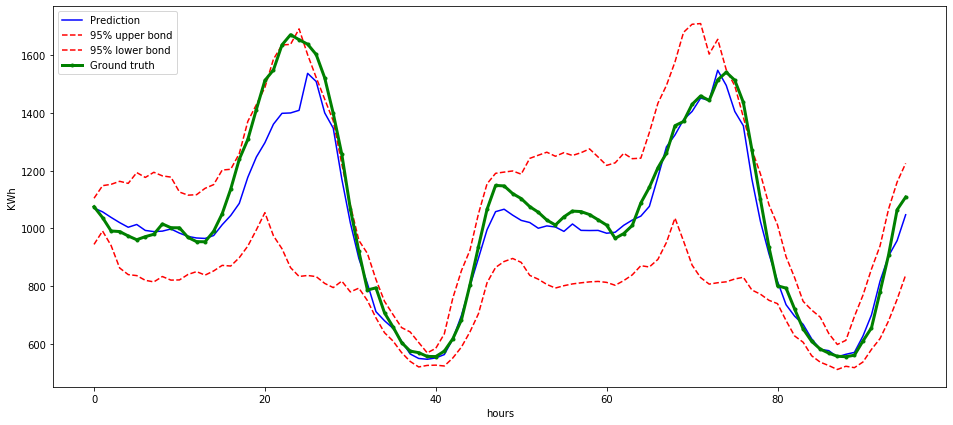

In [190]:
fig = plt.figure(figsize=(16,7))

plt.plot(ypred[1:2,:].reshape(-1,1), 'b-',label='Prediction')
plt.plot(ypred_ub[1:2,:].reshape(-1,1), 'r--', label='95% upper bond')
plt.plot(ypred_lb[1:2,:].reshape(-1,1), 'r--', label='95% lower bond')
plt.plot(val_y.iloc[1:2,:].to_numpy().reshape(-1,1), 'g.-', label='Ground truth', lw = 3)
#plt.fill(np.concatenate([xx, xx[::-1]]),
#         np.concatenate([y_upper, y_lower[::-1]]),
#         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('hours')
plt.ylabel('KWh')
plt.legend(loc='upper left')
plt.show()

### Testing set

In [191]:
## feature scaling
# single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
mtest = mmscaler.transform(ftest)

## feature pick up
test_x = mtest[:,cols]
test_y = ttest

In [192]:
ypred_t_lb = mlr_lb.predict(test_x[:5,:])
ypred_t_ub = mlr_ub.predict(test_x[:5,:])
ypred_t = mlr.predict(test_x[:5,:])

**Metrics**

In [200]:
o_yt = np.transpose(test_y.iloc[3:4,:].to_numpy())
p_yt = np.transpose(ypred_t[4:5,:])
get_eval(o_yt, p_yt)

MSE: 28158.256035499897
MAE: 127.15439794948765
r2_score: 0.8271237981199482


**Visualization**


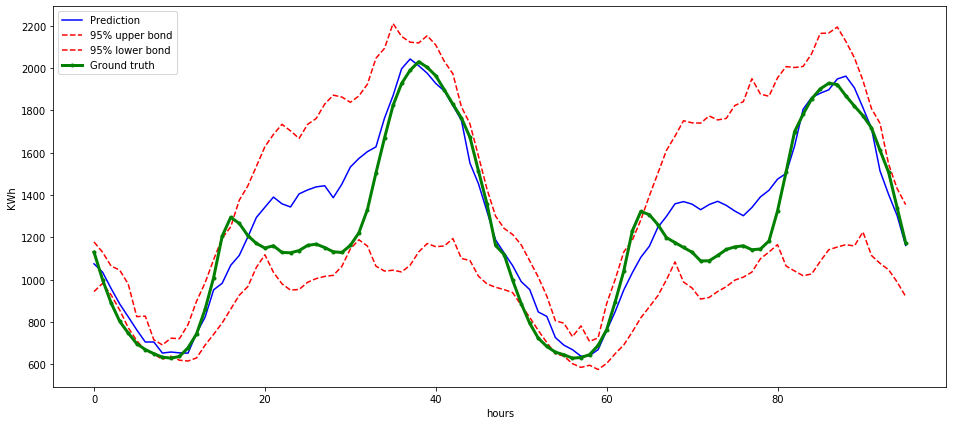

In [194]:
fig = plt.figure(figsize=(16,7))

plt.plot(ypred_t[0:1,:].reshape(-1,1), 'b-',label='Prediction')
plt.plot(ypred_t_ub[0:1,:].reshape(-1,1), 'r--', label='95% upper bond')
plt.plot(ypred_t_lb[0:1,:].reshape(-1,1), 'r--', label='95% lower bond')
plt.plot(test_y.iloc[0:1,:].to_numpy().reshape(-1,1), 'g.-', label='Ground truth', lw = 3)
#plt.fill(np.concatenate([xx, xx[::-1]]),
#         np.concatenate([y_upper, y_lower[::-1]]),
#         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('hours')
plt.ylabel('KWh')
plt.legend(loc='upper left')
plt.show()



### Random Forest Regression: Manual ML

In [128]:
from sklearn.ensemble import RandomForestRegressor

X = mt_feature
y = ttrain

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

rfr = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=100)
rfr.fit(train_X, train_y)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [129]:
yhat = rfr.predict(val_X)

### Result evaluation: validation set

**Metrics**


In [130]:
get_eval(val_y, yhat)

MSE: 8070.397340377949
MAE: 46.609515140911675
r2_score: 0.9704237803369036


**Visualization**

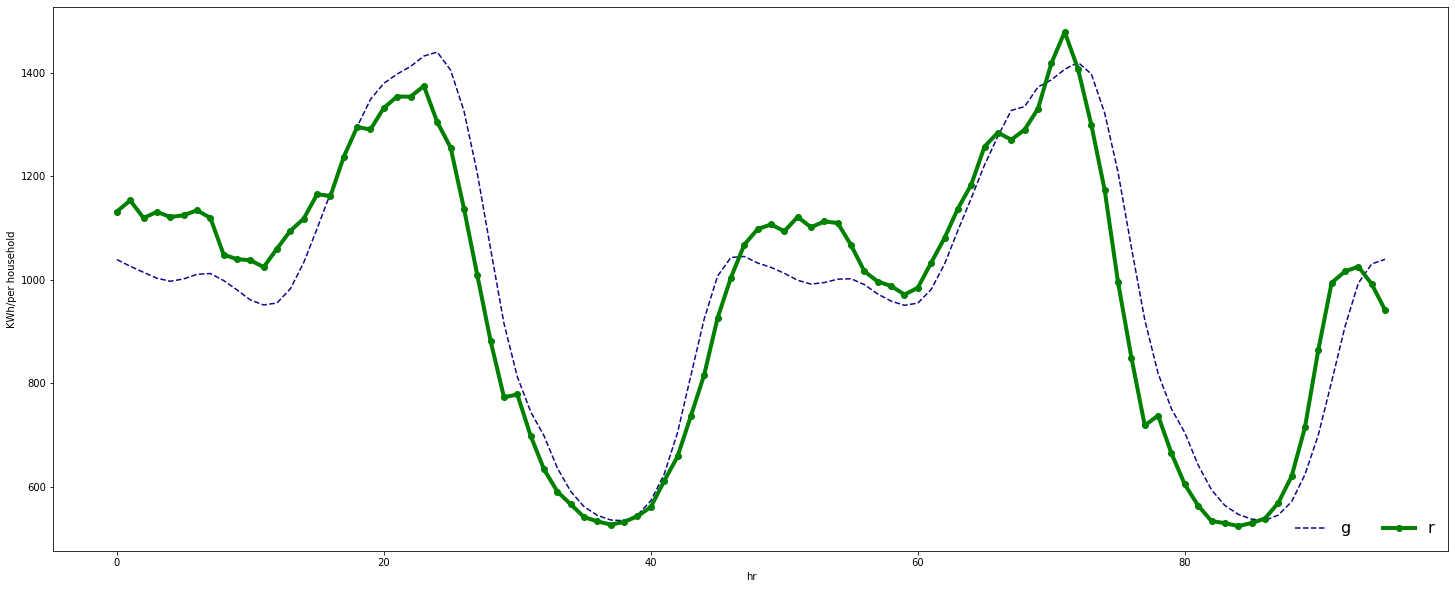

In [132]:
## assignment
real = val_y.to_numpy()
guess = yhat
real = real[:1,:96]
guess = guess[:1,:96]
rpdf = plot_df(real, "r")
gpdf = plot_df(guess, "g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

### Result evaluation: test set

**Data preparation for test set**

- prepare recency features
- feature scaling 
- identify feature picked from previous training process

In [133]:
## feature scaling
# single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
mtest = mmscaler.transform(ftest)

## feature pick up
test_x = mtest[:,cols]
test_y = ttest

In [134]:
## Prediction with test data
yt_hat = rfr.predict(test_x)

**Performance**

In [135]:
get_eval(test_y, yt_hat)

MSE: 11011.348133882544
MAE: 73.67232610418345
r2_score: 0.9307518864317372


**Visualization**

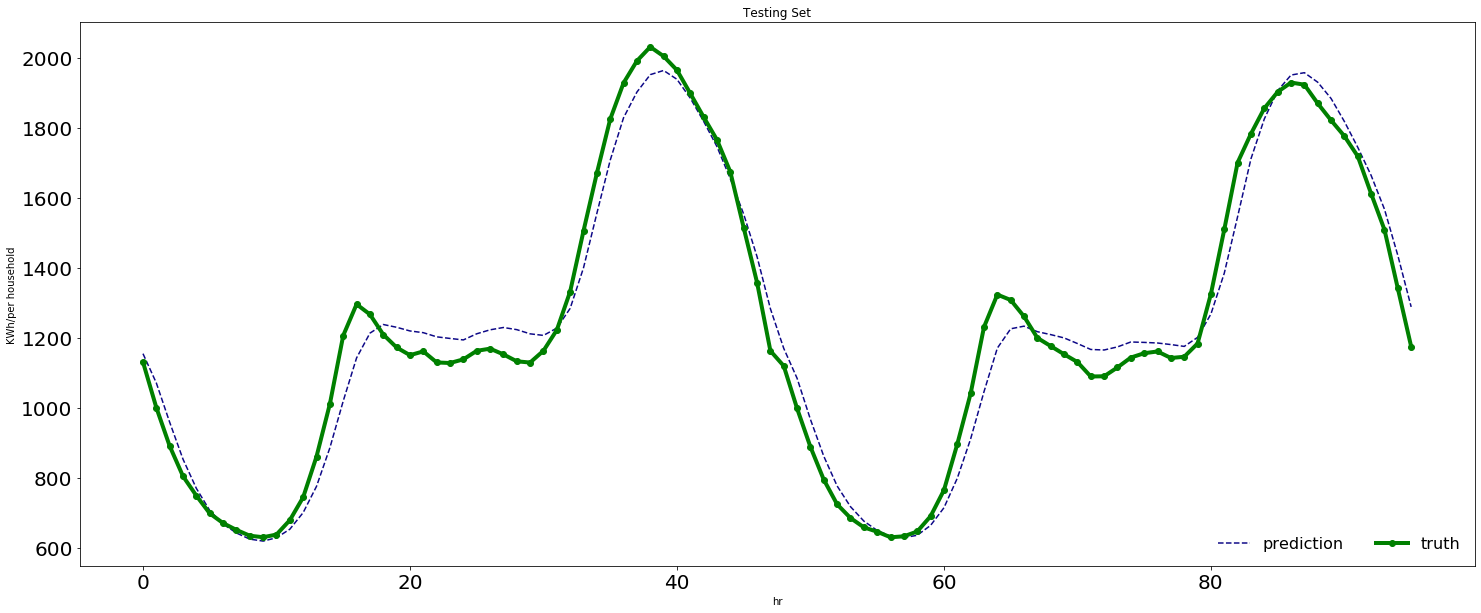

In [136]:
real = test_y.to_numpy()
guess = yt_hat
real = real[0:1,:96]
guess = guess[0:1,:96]
rpdf = plot_df(real,"truth")
gpdf = plot_df(guess,"prediction")
    
#plot 
ax = plt.gca()
ax.title.set_size(20)

gpdf.plot(title = "Testing Set", figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax,fontsize= 20)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

### Xgboost: Manual

In [137]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

X = mt_feature
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

xgbr = xgb.XGBRegressor(max_depth=10, njobs= 4)
mr = MultiOutputRegressor(xgbr, n_jobs = 4)
mr.fit(train_X, train_y)
#rc = MultiOutputRegressor(xgbr, cv = 5, random_state = 123)
#rc.fit(train_X, train_y)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=10, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, njobs=4, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                        

### Result evaluation: test set

In [138]:
yhat = mr.predict(val_X)

In [139]:
get_eval(val_y, yhat)

MSE: 6782.631476369782
MAE: 41.96216382445107
r2_score: 0.97505903984617


**Visualization**

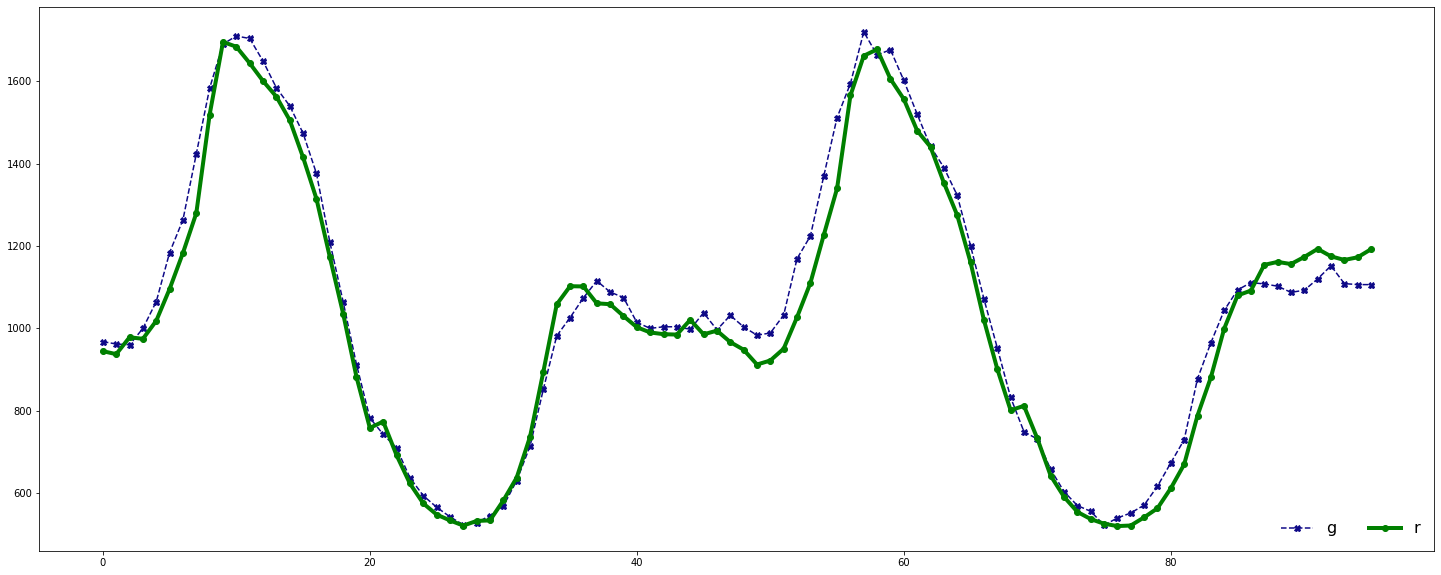

In [144]:
real = val_y.to_numpy()
guess = yhat
real = real[1:2,:96]
guess = guess[1:2,:96]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Result evaluation: test set

In [145]:
yhat = mr.predict(test_x)

In [146]:
get_eval(test_y, yhat)

MSE: 11403.41431283326
MAE: 73.57078548833333
r2_score: 0.9282862625175581


**Visualization**


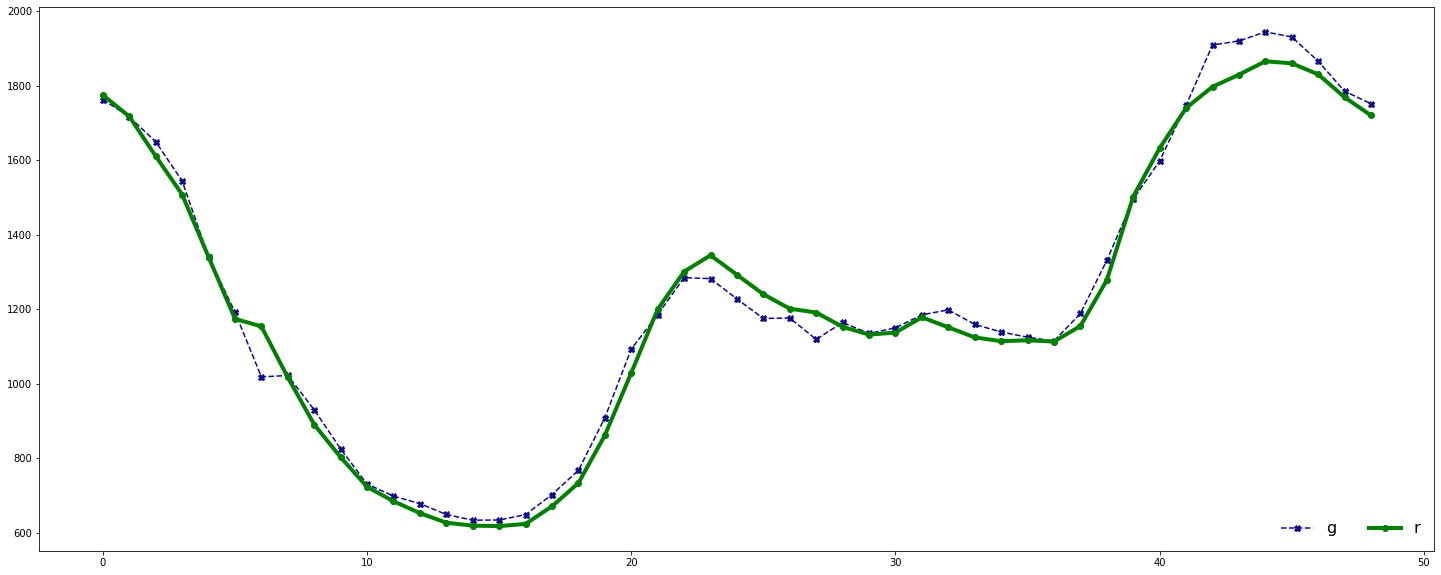

In [147]:
real = test_y.to_numpy()
guess = yhat
real = real[90:91,:49]
guess = guess[90:91,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### LSTM

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 50)             12200     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 1, 96)             4896      
Total params: 17,096
Trainable params: 17,096
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 3s - loss: 933457.9555
Epoch 2/50
 - 2s - loss: 693238.6110
Epoch 3/50
 - 2s - loss: 392925.0733
Epoch 4/50
 - 2s - loss: 193871.5715
Epoch 5/50
 - 2s - loss: 120083.6844
Epoch 6/50
 - 2s - loss: 104187.8377
Epoch 7/50
 - 2s - loss: 100139.4633
Epoch 8/50
 - 2s - loss: 97760.6811
Epoch 9/50
 - 2s - loss: 96170.4118
Epoch 10/50
 - 2s - loss: 94961.4260
Epoch 11/50
 - 2s - loss: 93849.1502
Epoch 12/50
 - 2s - loss: 92949.5286
Epoch 13/50
 - 2s - loss: 92296.0201
Epoch 14/50
 - 2s - loss: 91801.8

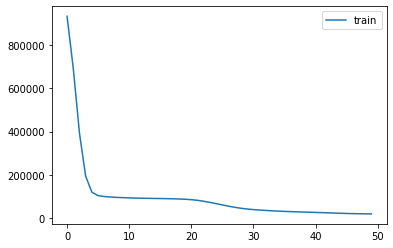

In [149]:
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

train_X, val_X, train_y, val_y = train_test_split(mt_feature, ttrain, train_size = 0.7, test_size = 0.3)
ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
ltrain_y = train_y.to_numpy().reshape((train_y.shape[0],1, train_y.shape[1]))

# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(96)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, ltrain_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

### Validation sets

**Metrics**


In [150]:
yhat = model.predict(val_X.reshape(val_X.shape[0], 1, val_X.shape[1]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])

In [153]:
get_eval(val_y, yhat)

MSE: 19529.31616290541
MAE: 82.99164153984434
r2_score: 0.9284311890208347


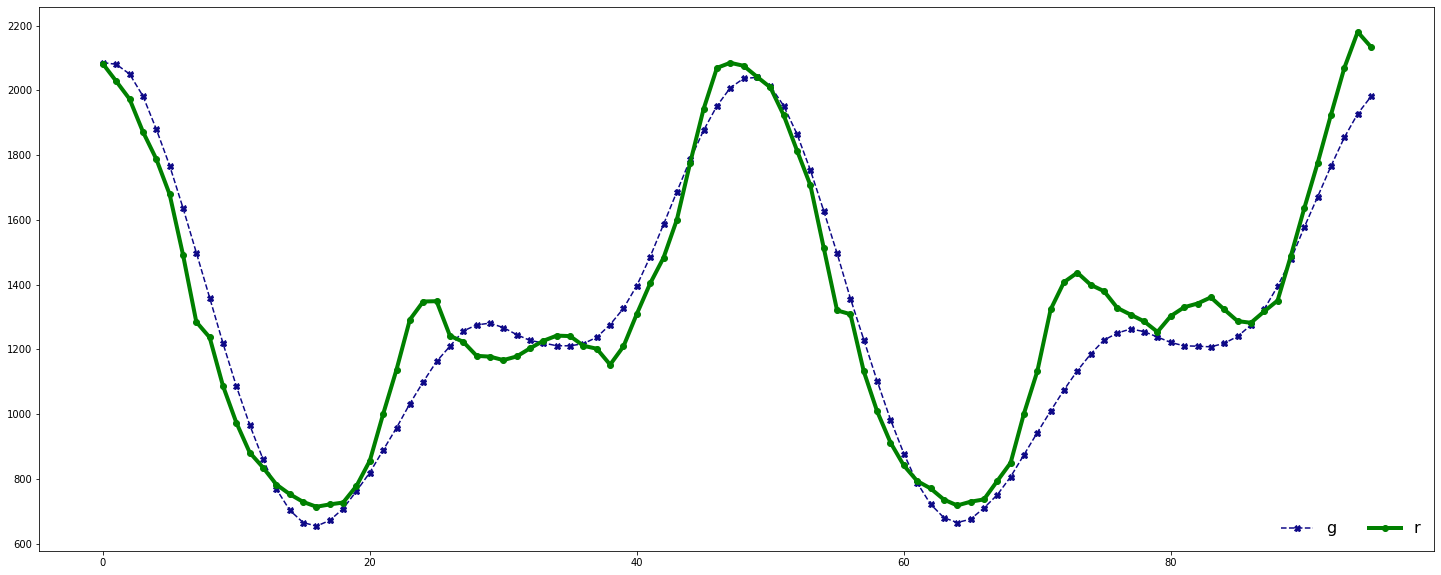

In [157]:
real = val_y.to_numpy()
guess = yhat
real = real[1:2,:96]
guess = guess[1:2,:96]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Testing sets

In [158]:
yhat = model.predict(test_x.reshape(test_x.shape[0], 1, test_x.shape[1]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])

**Metrics**

In [159]:
get_eval(test_y.iloc[:1,:].to_numpy().reshape(-1,1), yhat[:1,:].reshape(-1,1))

MSE: 18457.877717528554
MAE: 99.613075093571
r2_score: 0.8867621714987617


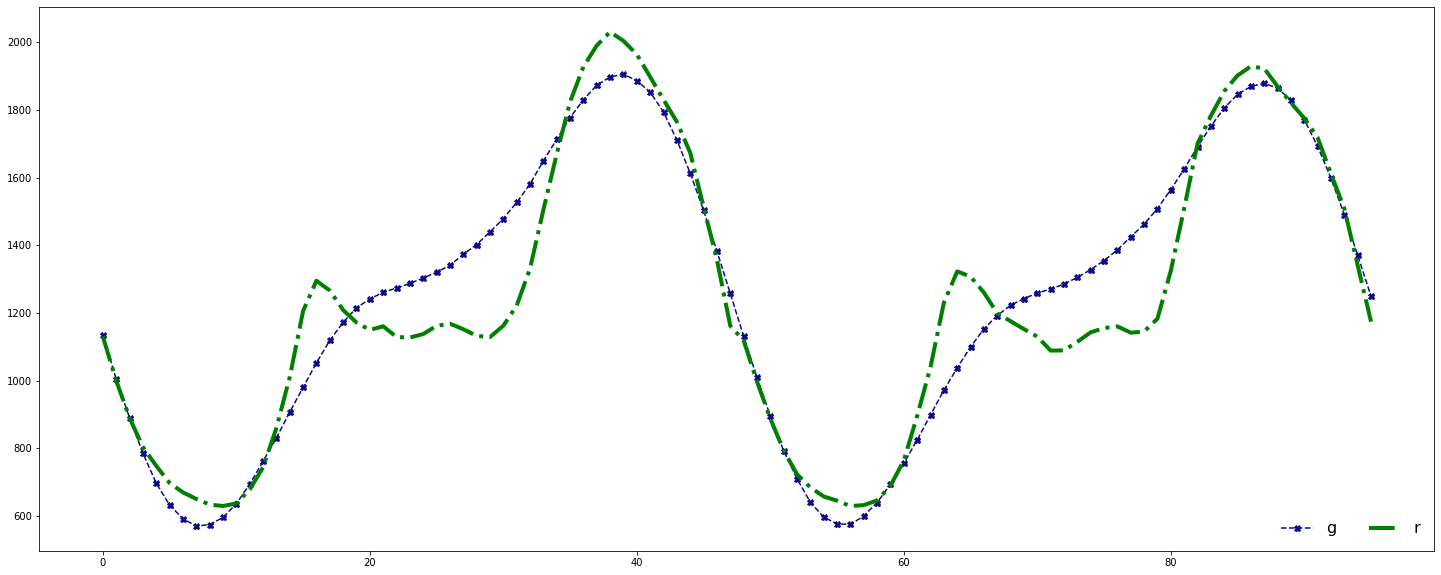

In [170]:
real = test_y.to_numpy()
guess = yhat
real = real[0:1,:96]
guess = guess[0:1,:96]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()